### Dataset inspection ###

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("Strikers.csv")
pd.set_option("display.max_columns", None)

df.head()
df.shape
df.info()
df.isna().mean().sort_values(ascending=False)
df.columns = df.columns.str.strip()
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 97 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player                               213 non-null    object 
 1   Season                               213 non-null    object 
 2   Age                                  213 non-null    int64  
 3   Team                                 213 non-null    object 
 4   Goals                                213 non-null    float64
 5   Assist                               213 non-null    float64
 6   G+A                                  213 non-null    float64
 7   Non_penalty_goals                    213 non-null    float64
 8   Penalty_kicks-made                   213 non-null    float64
 9   Penalty_kicks_attempted              213 non-null    float64
 10  Penalty_kicks_missed                 213 non-null    float64
 11  Expected_goals                  

In [7]:
TARGET_COL = "Tier_league"   # your binary target

# --- Target distribution ---
counts = df[TARGET_COL].value_counts(dropna=False).sort_index()
props = (counts / len(df)).round(4)

target_dist = pd.DataFrame({
    "count": counts,
    "percent": (props * 100).round(2)
})

print("\nTarget distribution:")
display(target_dist)

# --- Quick baseline expectations ---
majority_class = counts.idxmax()
majority_acc = counts.max() / len(df)

print(f"\nMajority class: {majority_class}")
print(f"Majority-class accuracy baseline: {majority_acc:.3f}")

# --- Optional: check for unexpected labels ---
unique_labels = sorted(df[TARGET_COL].unique())
print("\nUnique target labels:", unique_labels)



Target distribution:


,count,percent
Tier_league,,
0,163,76.53
1,50,23.47



Majority class: 0
Majority-class accuracy baseline: 0.765

Unique target labels: [np.int64(0), np.int64(1)]


In [9]:
# --- Identify columns ---
ID_COLS = ["Player", "Season", "Team", "Role"]
TARGET_COL = "Tier_league"

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# remove target from numeric feature list
numeric_features = [c for c in numeric_cols if c != TARGET_COL]

print("Number of numeric features (pre-reduction):", len(numeric_features))


Number of numeric features (pre-reduction): 92


In [11]:
# --- Variance and sparsity ---
var_df = pd.DataFrame({
    "variance": df[numeric_features].var(),
    "mean": df[numeric_features].mean(),
    "std": df[numeric_features].std(),
    "zero_ratio": (df[numeric_features] == 0).mean()
})

var_df = var_df.sort_values("variance")

display(var_df.head(15))
display(var_df.tail(15))


,variance,mean,std,zero_ratio
Own_goals,0.000047,0.000469,0.006852,0.995305
Penalty_kicks_conceded,0.000319,0.003286,0.017870,0.967136
Mistakes_leadto_shot,0.000617,0.006573,0.024839,0.934272
Penalty_kicks_missed,0.000777,0.008451,0.027880,0.915493
Red_cards,0.000855,0.009390,0.029237,0.906103
Penalty_kicks_won,0.003353,0.039906,0.057904,0.643192
Penalty_kicks-made,0.004628,0.042723,0.068032,0.661972
Penalty_kicks_attempted,0.006067,0.055399,0.077894,0.586854
Non_penalty_expGoals_perShot,0.006786,0.011878,0.082378,0.478873
Expected_assists,0.007274,0.093897,0.085287,0.276995


,variance,mean,std,zero_ratio
Tkld_During_Take_On%,173.595015,50.613146,13.175546,0.0
Carries/90,287.089336,51.168545,16.943711,0.0
Long_passes_Cmp%,329.025562,8.698122,18.139062,0.0
Passes_completition%,383.398983,31.294836,19.580577,0.0
Medium_pass_Cmp%,598.563899,16.161033,24.465566,0.0
Passes_toShot,611.206194,59.924413,24.722585,0.0
Short_passes_Cmp%,622.758451,22.963850,24.955129,0.0
Completed_medium_passes,633.197982,67.251174,25.163425,0.0
Completed_long_passes,637.445528,60.622535,25.247684,0.0
Completed_short_passes,1689.933409,43.476526,41.108800,0.0


In [14]:
DROP_LOW_VARIANCE = [
    "Own_goals",
    "Penalty_kicks_conceded",
    "Mistakes_leadto_shot",
    "Penalty_kicks_missed",
    "Red_cards"
]

df_reduced = df.drop(columns=DROP_LOW_VARIANCE)
print("Shape after low-variance pruning:", df_reduced.shape)


Shape after low-variance pruning: (213, 92)


In [16]:
import pandas as pd
import numpy as np

TARGET_COL = "Tier_league"

# numeric features excluding target
num_features = [
    c for c in df_reduced.select_dtypes(include=[np.number]).columns
    if c != TARGET_COL
]

# compute correlations
corr_target = (
    df_reduced[num_features]
    .corrwith(df_reduced[TARGET_COL])
    .sort_values(key=lambda x: x.abs(), ascending=False)
)

corr_df = corr_target.to_frame(name="corr_with_target")
corr_df["abs_corr"] = corr_df["corr_with_target"].abs()

display(corr_df.head(20))
display(corr_df.tail(20))


,corr_with_target,abs_corr
G+A,0.422491,0.422491
Attempted_short_passes,0.399511,0.399511
PassLive_lead_shot_attempt,0.393538,0.393538
Passes_into_last3rd,0.389354,0.389354
xG+xAssisted_G,0.388999,0.388999
PassLive_lead_goal,0.388454,0.388454
Expected_assists,0.378208,0.378208
Passes_attempted,0.375350,0.375350
Carries_into_final_third,0.367892,0.367892
Non_penalty_expGoals+assisted_goals,0.363031,0.363031


,corr_with_target,abs_corr
Goal_creating_actions,0.101086,0.101086
Tackles_on_players,-0.100018,0.100018
Yellow_cards,-0.098229,0.098229
Tackles_won,-0.091654,0.091654
Shots_onTarget,0.091329,0.091329
Dispossesd,-0.079110,0.079110
Recov_loose_balls,0.071504,0.071504
Tackles_+Interc,-0.070670,0.070670
Shots_onTarget%,0.067163,0.067163
Offsides,-0.062991,0.062991


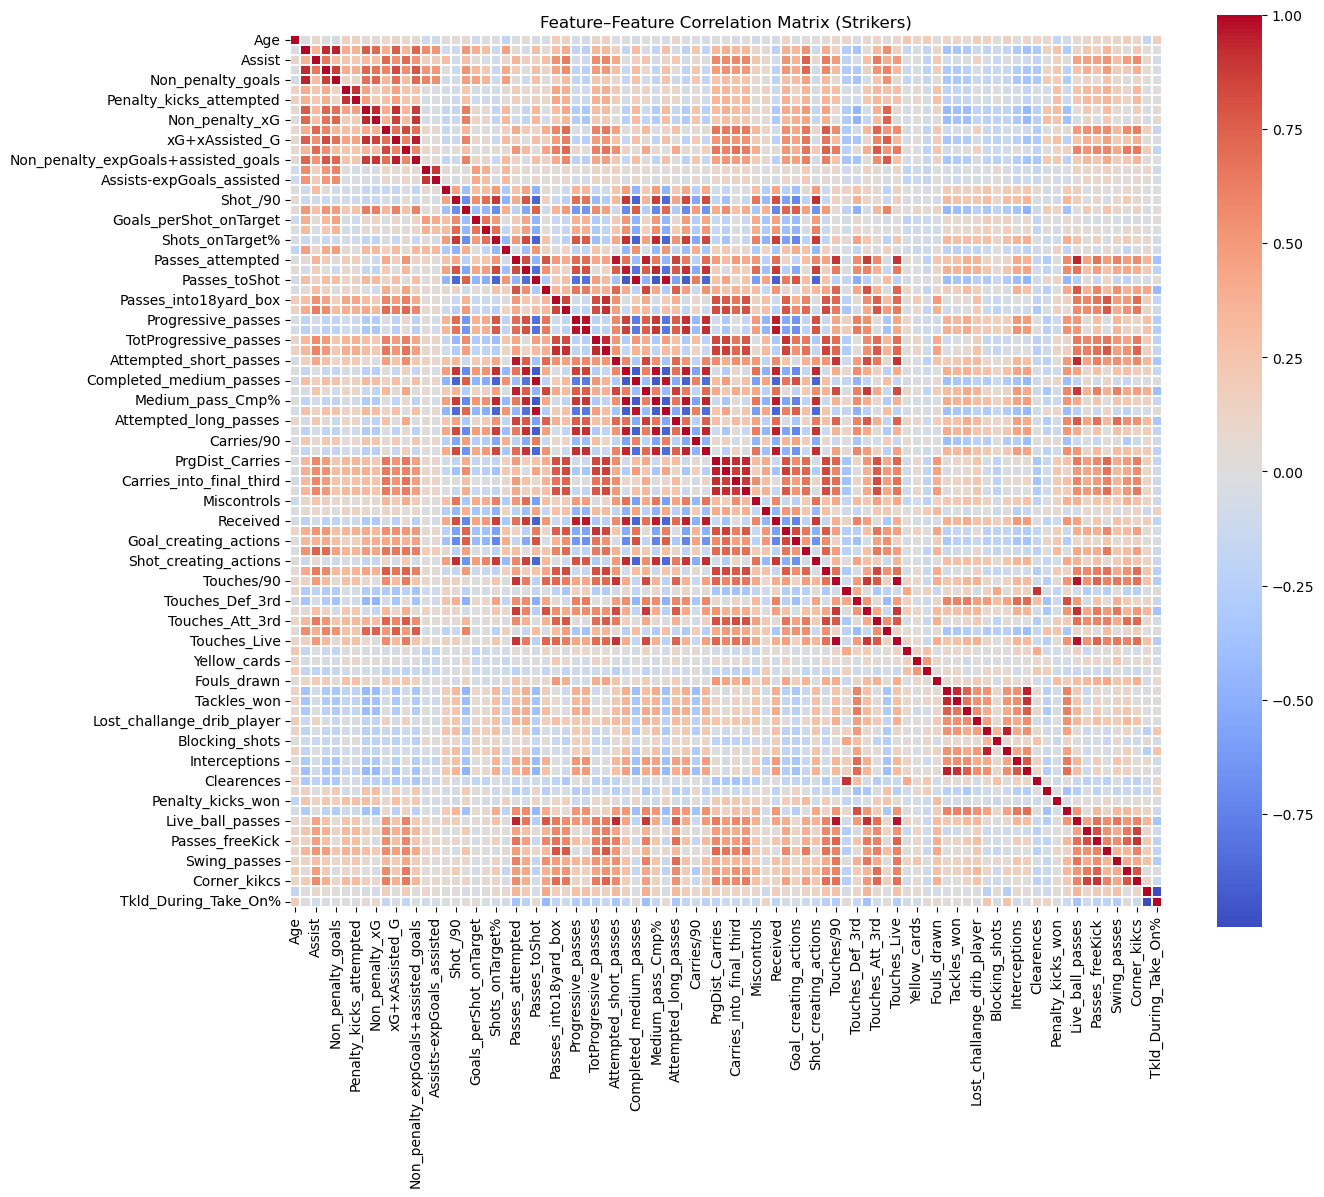

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# numeric features only
num_features = [
    c for c in df_reduced.select_dtypes(include=[np.number]).columns
    if c != TARGET_COL
]

corr_matrix = df_reduced[num_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.3
)
plt.title("Feature–Feature Correlation Matrix (Strikers)")
plt.tight_layout()
plt.show()


In [26]:


TARGET_COL = "Tier_league"

num_features = [
    c for c in df_reduced.select_dtypes(include=[np.number]).columns
    if c != TARGET_COL
]

# absolute correlation matrix
corr = df_reduced[num_features].corr().abs()

# extract high-correlation pairs
THRESH = 0.85

pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
)

pairs.columns = ["f1", "f2", "abs_corr"]

high_corr_pairs = pairs[pairs["abs_corr"] >= THRESH].sort_values(
    "abs_corr", ascending=False
)

print(f"Number of high-correlation pairs (|corr| ≥ {THRESH}):",
      len(high_corr_pairs))

display(high_corr_pairs.head(20))


Number of high-correlation pairs (|corr| ≥ 0.85): 123


,f1,f2,abs_corr
3218,Touches/90,Touches_Live,0.999976
3740,Succ_Takes_on%,Tkld_During_Take_On%,0.996732
2312,Short_passes_Cmp%,Medium_pass_Cmp%,0.990083
1797,Passes_toShot,Completed_medium_passes,0.990015
1800,Passes_toShot,Completed_long_passes,0.983167
2030,Progressive_passes,TotDist_completed_passes,0.975359
2468,Medium_pass_Cmp%,Long_passes_Cmp%,0.974349
3407,Touches_Live,Live_ball_passes,0.972181
3236,Touches/90,Live_ball_passes,0.971866
2365,Completed_medium_passes,Completed_long_passes,0.965917


In [28]:
from collections import defaultdict, deque

def build_corr_clusters(pairs_df):
    graph = defaultdict(set)

    for f1, f2 in pairs_df[["f1", "f2"]].values:
        graph[f1].add(f2)
        graph[f2].add(f1)

    seen = set()
    clusters = []

    for node in graph:
        if node in seen:
            continue

        q = deque([node])
        comp = set([node])
        seen.add(node)

        while q:
            u = q.popleft()
            for v in graph[u]:
                if v not in seen:
                    seen.add(v)
                    comp.add(v)
                    q.append(v)

        clusters.append(sorted(comp))

    # sort clusters by size (largest first)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters


clusters_graph = build_corr_clusters(high_corr_pairs)


In [30]:
for i, cluster in enumerate(clusters_graph, 1):
    print(f"\nGraph Cluster {i} (size={len(cluster)}):")
    for f in cluster:
        print(f"  - {f}")



Graph Cluster 1 (size=14):
  - Completed_long_passes
  - Completed_medium_passes
  - Long_passes_Cmp%
  - Medium_pass_Cmp%
  - Passes_completition%
  - Passes_toShot
  - Progressive_passes
  - Received
  - Short_passes_Cmp%
  - Shot_/90
  - Shot_creating_actions
  - Shots_onTarget%
  - TotDist_Carries
  - TotDist_completed_passes

Graph Cluster 2 (size=10):
  - Carries_10yards_forward
  - Carries_into18yard_box
  - Carries_into_final_third
  - Completed_short_passes
  - Crosses_into18yard_box
  - PassLive_lead_shot_attempt
  - Passes_into18yard_box
  - PrgDist_Carries
  - Prg_passes_received
  - TotProgressive_passes

Graph Cluster 3 (size=9):
  - Attempted_long_passes
  - Attempted_medium_passes
  - Attempted_short_passes
  - Live_ball_passes
  - Passes_attempted
  - Passes_into_last3rd
  - Touches/90
  - Touches_Live
  - Touches_Mid_3rd

Graph Cluster 4 (size=4):
  - Expected_goals
  - Non_penalty_expGoals+assisted_goals
  - Non_penalty_xG
  - xG+xAssisted_G

Graph Cluster 5 (size=3

In [32]:
clustered_features = set(f for cluster in clusters_graph for f in cluster)

singleton_features = sorted(
    set(num_features) - clustered_features
)

print("Number of singleton (non-redundant) features:", len(singleton_features))


Number of singleton (non-redundant) features: 31


In [38]:
DROP_FEATURES = [
    # Cluster 1
    "Completed_long_passes", "Completed_medium_passes",
    "Long_passes_Cmp%", "Medium_pass_Cmp%", "Short_passes_Cmp%",
    "Passes_completition%", "Passes_toShot", "Received",
    "Shot_/90", "Shots_onTarget%", "TotDist_Carries",
    "TotDist_completed_passes",

    # Cluster 2
    "Carries_10yards_forward", "PrgDist_Carries",
    "Completed_short_passes", "Crosses_into18yard_box",
    "Passes_into18yard_box", "Prg_passes_received",
    "TotProgressive_passes", "PassLive_lead_shot_attempt",

    # Cluster 3
    "Attempted_short_passes", "Attempted_medium_passes",
    "Attempted_long_passes", "Touches_Live",
    "Touches_Mid_3rd", "Live_ball_passes",
    "Passes_into_last3rd",

    # Cluster 4
    "Expected_goals", "Non_penalty_xG",
    "Non_penalty_expGoals+assisted_goals",

    # Cluster 5
    "Goals", "Non_penalty_goals",

    # Cluster 6
    "Tackles_won", "Tackles_on_players", "Tackles_+Interc",

    # Cluster 7
    "Dead_ball_pass", "Passes_freeKick",

    # Cluster 8
    "Tkld_During_Take_On%",

    # Cluster 9
    "Blocking_ball", "Blocking_pass",

    # Cluster 10
    "Penalty_kicks_attempted",

    # Cluster 11
    "Clearences", "Touches_Def_Pen",

    # Cluster 12
    "Goals-Expected_goals", "Assists-expGoals_assisted"
]


In [40]:
df_strikers_final = df_reduced.drop(columns=DROP_FEATURES)

print("Final shape:", df_strikers_final.shape)

# Save for next session
df_strikers_final.to_csv("Strikers_pruned_v2.csv", index=False)


Final shape: (213, 47)


In [4]:
ID_COLS = ["Player", "Season", "Team", "Role"]
TARGET_COL = "Tier_league"

# sanity check
print("Target distribution:")
print(df[TARGET_COL].value_counts(normalize=True).round(3))



Target distribution:
Tier_league
0    0.765
1    0.235
Name: proportion, dtype: float64


In [24]:
DROP = [
    "Blocking_shots",
    "Touches_Def_3rd",
    "Interceptions",
    "Tackles_on_dribblers",
    "Non_penalty_expGoals_perShot"
]


In [26]:
df_drop = df.drop(columns=DROP)

print("Shape after mild pruning:", df_drop.shape)


Shape after mild pruning: (213, 42)


In [28]:
df_drop.to_csv("Strikers_model_ready_v2.csv", index=False)


### Baseline modelling

In [54]:
X = df_drop.drop(columns=ID_COLS + [TARGET_COL])
y = df_drop[TARGET_COL]

print("Feature matrix shape:", X.shape)


Feature matrix shape: (213, 37)


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (159, 37)
Test size: (54, 37)


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)

preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


In [57]:
def hit_at_k(y_true, y_score, k=20):
    """Share of true positives captured in top-k ranked by score."""
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = min(k, len(y_true))
    idx = np.argsort(-y_score)[:k]
    return y_true[idx].sum() / max(1, y_true.sum())
def ndcg_at_k(y_true, y_score, k=20):
    """NDCG@k for binary relevance."""
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = min(k, len(y_true))
    idx = np.argsort(-y_score)[:k]
    rel = y_true[idx]

    discounts = 1.0 / np.log2(np.arange(2, k + 2))
    dcg = np.sum(rel * discounts)

    ideal_rel = np.sort(y_true)[::-1][:k]
    idcg = np.sum(ideal_rel * discounts)

    return dcg / idcg if idcg > 0 else 0.0

def evaluate_binary(y_true, y_prob, threshold=0.5, k=20):
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        f"hit@{k}": hit_at_k(y_true, y_prob, k=k),
        f"ndcg@{k}": ndcg_at_k(y_true, y_prob, k=k),
    }

    cm = confusion_matrix(y_true, y_pred)
    return metrics, cm

In [58]:
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=3000,
        solver="liblinear",
        class_weight="balanced",
        random_state=42
    ))
])


In [59]:
from xgboost import XGBClassifier

xgb = Pipeline([
    ("preprocess", preprocess),  # scaling not required, but harmless; keeps consistency
    ("model", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        min_child_weight=1.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])


In [60]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline([
    ("preprocess", preprocess),
    ("model", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        alpha=1e-3,
        learning_rate_init=1e-3,
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=2000,
        random_state=42
    ))
])


In [61]:
MODELS = {
    "Logistic": log_reg,
    "XGBoost": xgb,
    "MLP": mlp
}

results = []
cms = {}

for name, model in MODELS.items():
    model.fit(X_train, y_train)

    # predict probabilities for class 1
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics, cm = evaluate_binary(y_test.values, y_prob, threshold=0.5, k=20)
    metrics["model"] = name
    results.append(metrics)
    cms[name] = cm

results_df = pd.DataFrame(results).set_index("model").sort_values("ndcg@20", ascending=False)
display(results_df)

print("\nConfusion matrices (threshold=0.5):")
for name, cm in cms.items():
    print(f"\n{name}\n{cm}")


,accuracy,precision,recall,f1,roc_auc,pr_auc,hit@20,ndcg@20
model,,,,,,,,
XGBoost,0.759259,0.500000,0.461538,0.480,0.726079,0.608998,0.538462,0.647266
Logistic,0.703704,0.421053,0.615385,0.500,0.724203,0.506925,0.615385,0.624553
MLP,0.814815,1.000000,0.230769,0.375,0.681051,0.546300,0.538462,0.623204



Confusion matrices (threshold=0.5):

Logistic
[[30 11]
 [ 5  8]]

XGBoost
[[35  6]
 [ 7  6]]

MLP
[[41  0]
 [10  3]]


In [110]:
df_drop = pd.read_csv("Strikers_model_ready_v2.csv")

### Tuning 

In [112]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)


SEED = 42
TEST_SIZE = 0.25
K = 20

ID_COLS = ["Player", "Season", "Team", "Role"]
TARGET_COL = "Tier_league"

X = df_drop.drop(columns=ID_COLS + [TARGET_COL])
y = df_drop[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    stratify=y,
    random_state=SEED
)

print("Feature matrix shape:", X.shape)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)



preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


def ndcg_at_k(y_true, y_score, k=20):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = min(k, len(y_true))

    idx = np.argsort(-y_score)[:k]
    rel = y_true[idx]

    discounts = 1.0 / np.log2(np.arange(2, k + 2))
    dcg = np.sum(rel * discounts)

    ideal_rel = np.sort(y_true)[::-1][:k]
    idcg = np.sum(ideal_rel * discounts)

    return dcg / idcg if idcg > 0 else 0.0

def hit_at_k(y_true, y_score, k=20):
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)
    k = min(k, len(y_true))
    idx = np.argsort(-y_score)[:k]
    return y_true[idx].sum() / max(1, y_true.sum())

# Optimise cv ranker

def cv_rank_scores(model, X, y, k=20, n_splits=4, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)

    ndcgs, hits, rocs, pras = [], [], [], []

    for fold_i, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        m = clone(model)
        m.fit(X_tr, y_tr)

        y_prob = m.predict_proba(X_va)[:, 1]

        ndcgs.append(ndcg_at_k(y_va.values, y_prob, k=k))
        hits.append(hit_at_k(y_va.values, y_prob, k=k))
        rocs.append(roc_auc_score(y_va.values, y_prob))
        pras.append(average_precision_score(y_va.values, y_prob))

    return {
        "ndcg_mean": float(np.mean(ndcgs)),
        "ndcg_std": float(np.std(ndcgs)),
        "hit_mean": float(np.mean(hits)),
        "hit_std": float(np.std(hits)),
        "roc_mean": float(np.mean(rocs)),
        "pr_mean": float(np.mean(pras)),
    }

def tune_model(base_pipeline, param_grid, X, y, k=20, n_splits=4, seed=42, top_n=10):
    rows = []
    best_score = -1.0
    best_params = None

    for params in ParameterGrid(param_grid):
        model = clone(base_pipeline).set_params(**params)
        scores = cv_rank_scores(model, X, y, k=k, n_splits=n_splits, seed=seed)
        row = {**params, **scores}
        rows.append(row)

        if scores["ndcg_mean"] > best_score:
            best_score = scores["ndcg_mean"]
            best_params = params

    results = pd.DataFrame(rows).sort_values("ndcg_mean", ascending=False).reset_index(drop=True)
    print(f"Best NDCG@{k}: {best_score:.4f}")
    print("Best params:", best_params)
    display(results.head(top_n))
    return best_params, results

# Test set evaluation

def evaluate_on_test(model, X_train, y_train, X_test, y_test, k=20, threshold=0.5):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    out = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": average_precision_score(y_test, y_prob),
        f"hit@{k}": hit_at_k(y_test.values, y_prob, k=k),
        f"ndcg@{k}": ndcg_at_k(y_test.values, y_prob, k=k),
    }
    cm = confusion_matrix(y_test, y_pred)
    return out, cm


pipe_log = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        solver="liblinear",
        max_iter=4000,
        random_state=SEED
    ))
])


pipe_xgb = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=SEED
    ))
])

pipe_mlp = Pipeline([
    ("preprocess", preprocess),
    ("model", MLPClassifier(
        early_stopping=True,
        n_iter_no_change=20,
        max_iter=4000,
        random_state=SEED
    ))
])



grid_log = {
    "model__C": [0.05, 0.1, 0.3, 1.0, 3.0],
    "model__class_weight": [None, "balanced"]
}


grid_xgb = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [2, 3, 4, 5],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__min_child_weight": [1, 5],
    "model__reg_lambda": [1.0, 5.0]
}

grid_mlp = {
    "model__hidden_layer_sizes": [(32,), (64,), (64, 32), (128,)],
    "model__activation": ["relu", "tanh"],
    "model__alpha": [1e-5, 1e-4, 1e-3],
    "model__learning_rate_init": [1e-4, 5e-4, 1e-3]
}

# -------------------------
# 7) Run tuning (CV optimise NDCG@K)
# -------------------------
print("\n===== Tuning Logistic (CV NDCG@{}) =====".format(K))
best_log_params, log_results = tune_model(pipe_log, grid_log, X_train, y_train, k=K, n_splits=4, seed=SEED)

print("\n===== Tuning XGBoost (CV NDCG@{}) =====".format(K))
best_xgb_params, xgb_results = tune_model(pipe_xgb, grid_xgb, X_train, y_train, k=K, n_splits=4, seed=SEED)

print("\n===== Tuning MLP (CV NDCG@{}) =====".format(K))
best_mlp_params, mlp_results = tune_model(pipe_mlp, grid_mlp, X_train, y_train, k=K, n_splits=4, seed=SEED)

# -------------------------
# 8) Lock params, refit on train, evaluate on test
# -------------------------
best_log = clone(pipe_log).set_params(**best_log_params)
best_xgb = clone(pipe_xgb).set_params(**best_xgb_params)
best_mlp = clone(pipe_mlp).set_params(**best_mlp_params)

final_rows = []
final_cms = {}

for name, model in [
    ("Logistic_tuned", best_log),
    ("XGBoost_tuned", best_xgb),
    ("MLP_tuned", best_mlp),
]:
    metrics, cm = evaluate_on_test(model, X_train, y_train, X_test, y_test, k=K, threshold=0.5)
    metrics["model"] = name
    final_rows.append(metrics)
    final_cms[name] = cm

final_df = pd.DataFrame(final_rows).set_index("model").sort_values(f"ndcg@{K}", ascending=False)
print("\n===== TEST RESULTS (Locked Params) =====")
display(final_df)

print("\nConfusion matrices (threshold=0.5):")
for name, cm in final_cms.items():
    print(f"\n{name}\n{cm}")


Feature matrix shape: (212, 37)
Train size: (159, 37)
Test size: (53, 37)

===== Tuning Logistic (CV NDCG@20) =====
Best NDCG@20: 0.8690
Best params: {'model__C': 0.1, 'model__class_weight': 'balanced'}


,model__C,model__class_weight,ndcg_mean,ndcg_std,hit_mean,hit_std,roc_mean,pr_mean
0,0.10,balanced,0.868976,0.030431,0.894444,0.070929,0.861490,0.751680
1,0.30,balanced,0.862010,0.030410,0.894444,0.070929,0.860848,0.738912
2,0.30,None,0.853578,0.046573,0.866667,0.087489,0.853041,0.744348
3,0.05,None,0.846213,0.031550,0.838889,0.093459,0.851428,0.752904
4,3.00,None,0.845700,0.034640,0.866667,0.087489,0.852458,0.726827
5,1.00,balanced,0.845362,0.045607,0.866667,0.087489,0.859310,0.730974
6,3.00,balanced,0.844362,0.035719,0.866667,0.087489,0.849740,0.723017
7,0.05,balanced,0.841369,0.030380,0.838889,0.093459,0.855066,0.747405
8,0.10,None,0.840356,0.033841,0.838889,0.093459,0.851768,0.743293
9,1.00,None,0.836344,0.035443,0.838889,0.093459,0.857706,0.740028



===== Tuning XGBoost (CV NDCG@20) =====
Best NDCG@20: 0.8437
Best params: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__min_child_weight': 5, 'model__n_estimators': 200, 'model__reg_lambda': 1.0, 'model__subsample': 0.8}


,model__colsample_bytree,model__learning_rate,model__max_depth,model__min_child_weight,model__n_estimators,model__reg_lambda,model__subsample,ndcg_mean,ndcg_std,hit_mean,hit_std,roc_mean,pr_mean
0,1.0,0.1,3,5,200,1.0,0.8,0.843743,0.066346,0.838889,0.093459,0.838522,0.744930
1,1.0,0.1,2,5,200,1.0,0.8,0.843743,0.066346,0.838889,0.093459,0.838522,0.744930
2,1.0,0.1,4,5,200,1.0,0.8,0.843743,0.066346,0.838889,0.093459,0.838522,0.744930
3,1.0,0.1,5,5,200,1.0,0.8,0.843743,0.066346,0.838889,0.093459,0.838522,0.744930
4,0.7,0.1,3,5,400,1.0,0.8,0.840188,0.052845,0.838889,0.093459,0.842010,0.740591
5,0.7,0.1,2,5,400,1.0,0.8,0.840188,0.052845,0.838889,0.093459,0.842010,0.740591
6,0.7,0.1,5,5,400,1.0,0.8,0.840188,0.052845,0.838889,0.093459,0.842010,0.740591
7,0.7,0.1,4,5,400,1.0,0.8,0.840188,0.052845,0.838889,0.093459,0.842010,0.740591
8,1.0,0.1,4,5,400,5.0,0.8,0.837968,0.063389,0.838889,0.093459,0.836947,0.732923
9,1.0,0.1,5,5,400,5.0,0.8,0.837968,0.063389,0.838889,0.093459,0.836947,0.732923



===== Tuning MLP (CV NDCG@20) =====
Best NDCG@20: 0.8263
Best params: {'model__activation': 'tanh', 'model__alpha': 1e-05, 'model__hidden_layer_sizes': (128,), 'model__learning_rate_init': 0.001}


,model__activation,model__alpha,model__hidden_layer_sizes,model__learning_rate_init,ndcg_mean,ndcg_std,hit_mean,hit_std,roc_mean,pr_mean
0,tanh,0.00100,"(128,)",0.0010,0.826314,0.027745,0.863889,0.093087,0.827124,0.682768
1,tanh,0.00001,"(128,)",0.0010,0.826314,0.027745,0.863889,0.093087,0.827124,0.682768
2,tanh,0.00010,"(128,)",0.0010,0.826314,0.027745,0.863889,0.093087,0.827124,0.682768
3,tanh,0.00001,"(128,)",0.0005,0.825465,0.026115,0.863889,0.093087,0.823513,0.680047
4,tanh,0.00010,"(128,)",0.0005,0.825465,0.026115,0.863889,0.093087,0.823513,0.680047
5,tanh,0.00100,"(128,)",0.0005,0.825465,0.026115,0.863889,0.093087,0.823513,0.680047
6,relu,0.00010,"(128,)",0.0010,0.816155,0.047203,0.808333,0.094730,0.826189,0.713272
7,relu,0.00001,"(128,)",0.0010,0.816155,0.047203,0.808333,0.094730,0.826189,0.713272
8,relu,0.00100,"(128,)",0.0010,0.816155,0.047203,0.808333,0.094730,0.826189,0.713272
9,relu,0.00001,"(128,)",0.0005,0.804474,0.046494,0.808333,0.094730,0.803378,0.683684



===== TEST RESULTS (Locked Params) =====


,accuracy,precision,recall,f1,roc_auc,pr_auc,hit@20,ndcg@20
model,,,,,,,,
MLP_tuned,0.603774,0.320000,0.666667,0.432432,0.743902,0.567529,0.666667,0.692064
XGBoost_tuned,0.849057,0.833333,0.416667,0.555556,0.693089,0.555190,0.583333,0.635167
Logistic_tuned,0.660377,0.350000,0.583333,0.437500,0.745935,0.513047,0.583333,0.607985



Confusion matrices (threshold=0.5):

Logistic_tuned
[[28 13]
 [ 5  7]]

XGBoost_tuned
[[40  1]
 [ 7  5]]

MLP_tuned
[[24 17]
 [ 4  8]]


In [114]:
# ===============================
# SCOUTING TABLE (LOCKED MODELS)
# ===============================

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# ---------
# Features
# ---------
X_full = df_drop.drop(columns=ID_COLS + [TARGET_COL])
y_full = df_drop[TARGET_COL]

# ---------
# Pipelines with LOCKED params
# ---------

log_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        C=0.05,
        class_weight="balanced",
        max_iter=2000,
        random_state=SEED
    ))
])

mlp_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="tanh",
        alpha=1e-5,
        learning_rate_init=1e-3,
        max_iter=2000,
        random_state=SEED
    ))
])

xgb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=3,
        learning_rate=0.03,
        subsample=1.0,
        colsample_bytree=0.7,
        min_child_weight=1,
        reg_lambda=5.0,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=SEED
    ))
])

# ---------
# Fit on FULL data (scouting setup)
# ---------
log_pipe.fit(X_full, y_full)
mlp_pipe.fit(X_full, y_full)
xgb_pipe.fit(X_full, y_full)

# ---------
# Predict probabilities (Tier = 1)
# ---------
df_scout = df_drop[ID_COLS].copy()

df_scout["p_tier_logistic"] = log_pipe.predict_proba(X_full)[:, 1]
df_scout["p_tier_mlp"] = mlp_pipe.predict_proba(X_full)[:, 1]
df_scout["p_tier_xgb"] = xgb_pipe.predict_proba(X_full)[:, 1]

# Optional: ensemble average
df_scout["p_tier_mean"] = (
    df_scout["p_tier_logistic"]
    + df_scout["p_tier_mlp"]
    + df_scout["p_tier_xgb"]
) / 3

# ---------
# Sort for scouting
# ---------
df_scout = df_scout.sort_values(
    by="p_tier_xgb",   # main scouting signal
    ascending=False
).reset_index(drop=True)

# ---------
# Save
# ---------
df_scout.to_csv("Strikers_scouting_table.csv", index=False)

df_scout.head(20)


,Player,Season,Team,Role,p_tier_logistic,p_tier_mlp,p_tier_xgb,p_tier_mean
0,Kylian Mbappé,2021-2022,Paris S-G,CF,0.992921,0.999985,0.925022,0.972643
1,Neymar,2017-2018,Paris S-G,SS,0.998286,0.999632,0.923833,0.973917
2,Kylian Mbappé,2020-2021,Paris S-G,CF,0.990432,0.999970,0.919407,0.969936
3,Memphis,2017-2018,Lyon,CF,0.865483,0.999531,0.913754,0.926256
4,Memphis,2020-2021,Lyon,CF,0.911636,0.999933,0.905484,0.939018
5,Neymar,2019-2020,Paris S-G,SS,0.994145,0.999957,0.894124,0.962742
6,Kylian Mbappé,2018-2019,Paris S-G,CF,0.995313,0.999456,0.888358,0.961043
7,Memphis,2018-2019,Lyon,CF,0.803091,0.999406,0.880160,0.894219
8,Kylian Mbappé,2017-2018,2 Teams,CF,0.976016,0.999544,0.872764,0.949442
9,Kylian Mbappé,2019-2020,Paris S-G,CF,0.997060,0.999793,0.855211,0.950688


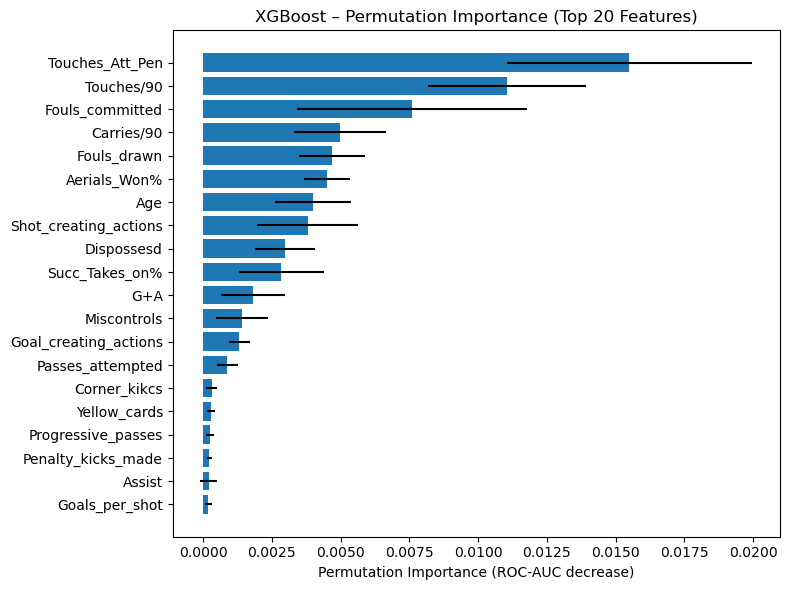

,feature,importance_mean,importance_std
23,Touches_Att_Pen,0.015504,0.004471
21,Touches/90,0.011043,0.002865
26,Fouls_committed,0.007596,0.004197
13,Carries/90,0.004983,0.001666
27,Fouls_drawn,0.004687,0.001186
24,Aerials_Won%,0.004495,0.000833
0,Age,0.004002,0.001374
20,Shot_creating_actions,0.003806,0.001833
17,Dispossesd,0.002971,0.001084
36,Succ_Takes_on%,0.002846,0.001531


In [116]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# Compute permutation importance
perm = permutation_importance(
    xgb_pipe,
    X_full,
    y_full,
    n_repeats=30,
    random_state=SEED,
    scoring="roc_auc"
)

perm_df = pd.DataFrame({
    "feature": X_full.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

# Keep top N
TOP_N = 20
perm_top = perm_df.head(TOP_N)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(
    perm_top["feature"][::-1],
    perm_top["importance_mean"][::-1],
    xerr=perm_top["importance_std"][::-1]
)
plt.xlabel("Permutation Importance (ROC-AUC decrease)")
plt.title("XGBoost – Permutation Importance (Top 20 Features)")
plt.tight_layout()
plt.show()

perm_top


In [118]:
import shap

# Extract trained XGB model (after imputation)
xgb_model = xgb_pipe.named_steps["model"]

# Apply the same preprocessing as the model
X_processed = xgb_pipe.named_steps["imputer"].transform(X_full)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_processed)


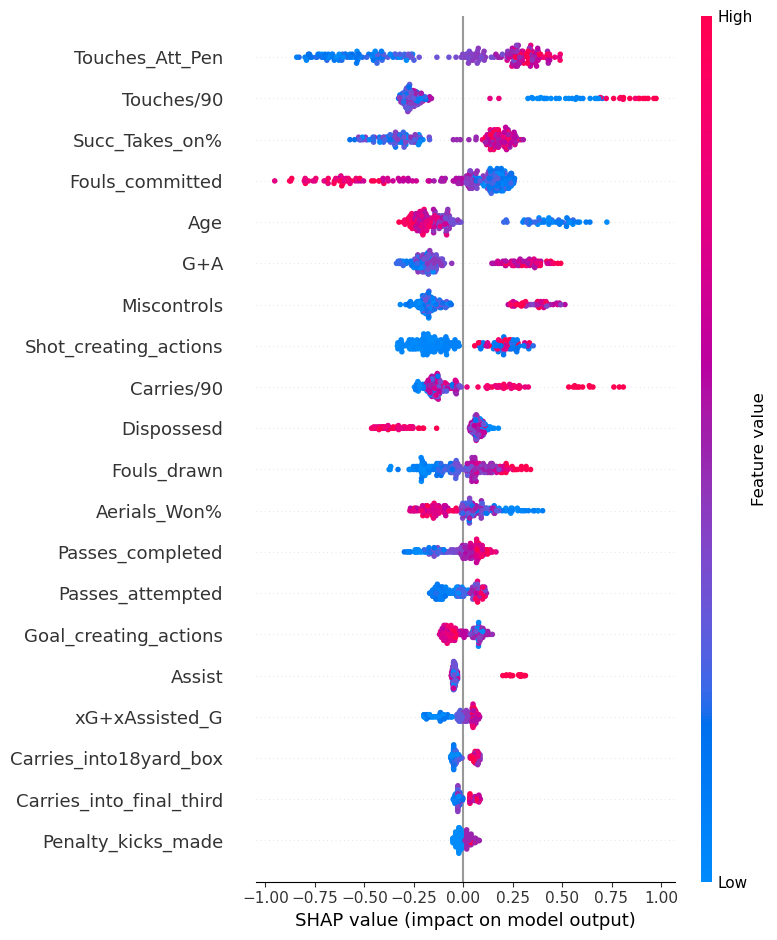

In [120]:
shap.summary_plot(
    shap_values,
    X_processed,
    feature_names=X_full.columns,
    max_display=20,
    show=True
)


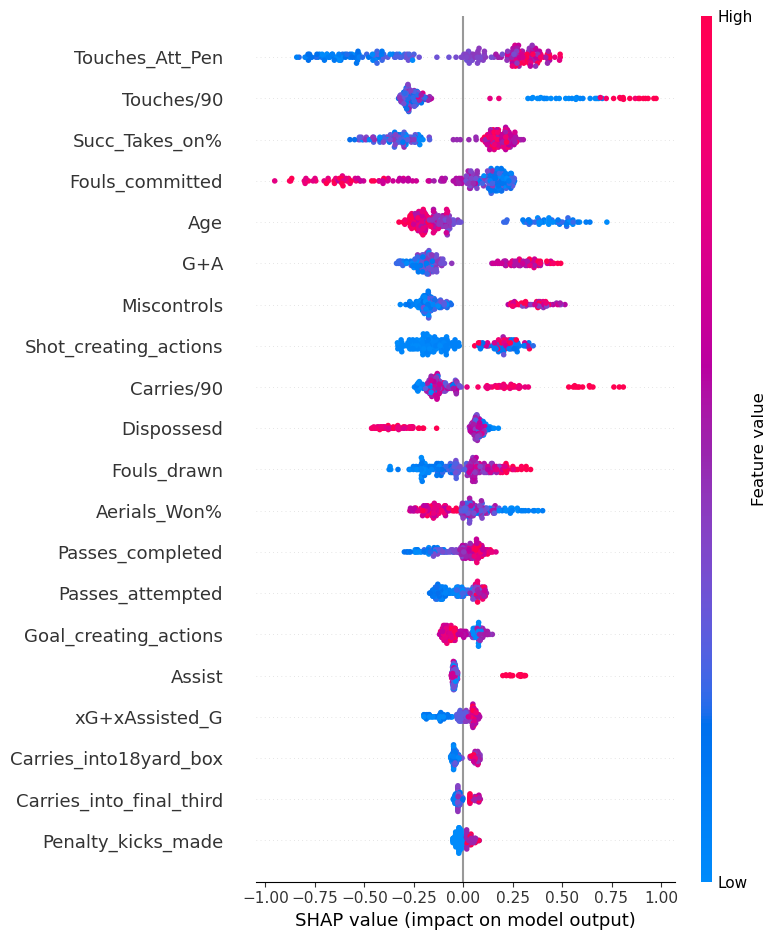

In [122]:
shap.summary_plot(
    shap_values,
    X_processed,
    feature_names=X_full.columns,
    max_display=20,
    show=True
)


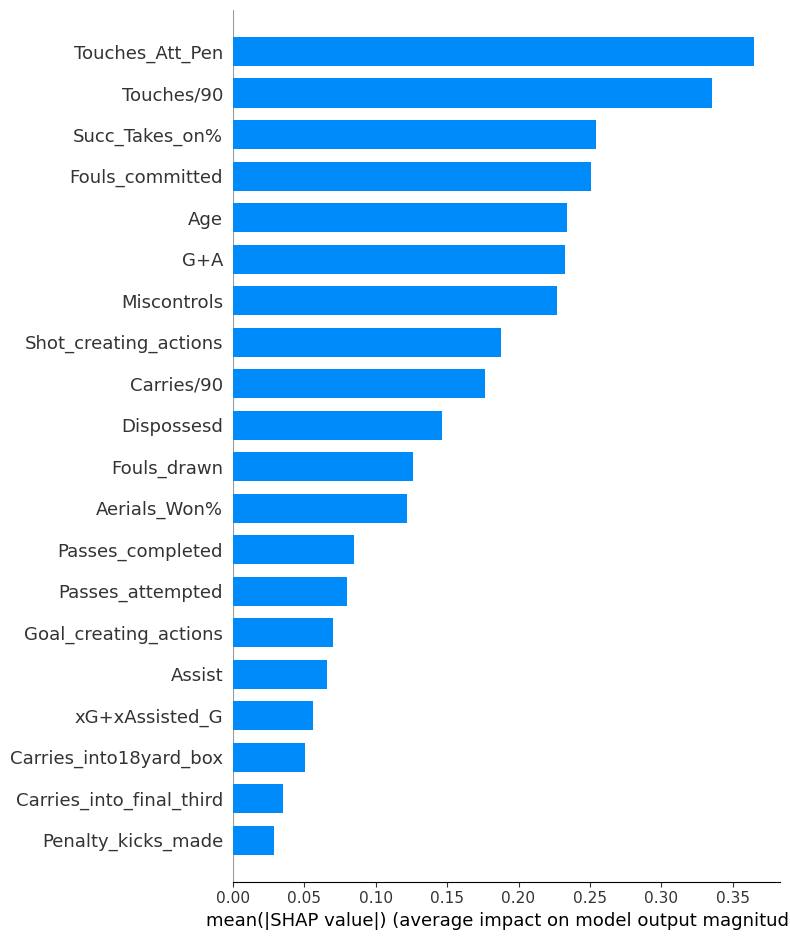

In [124]:
shap.summary_plot(
    shap_values,
    X_processed,
    feature_names=X_full.columns,
    plot_type="bar",
    max_display=20,
    show=True
)


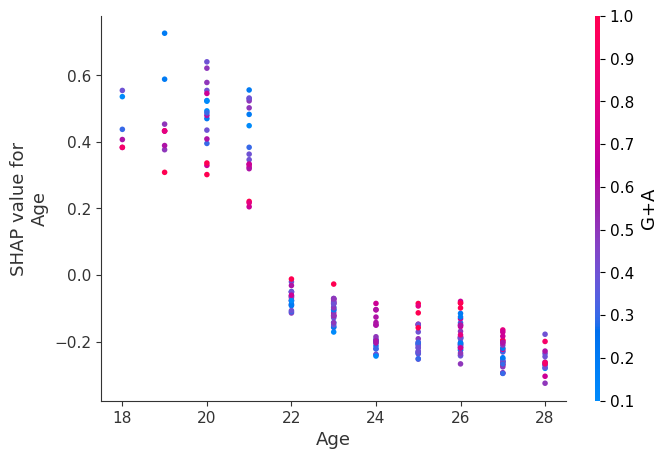

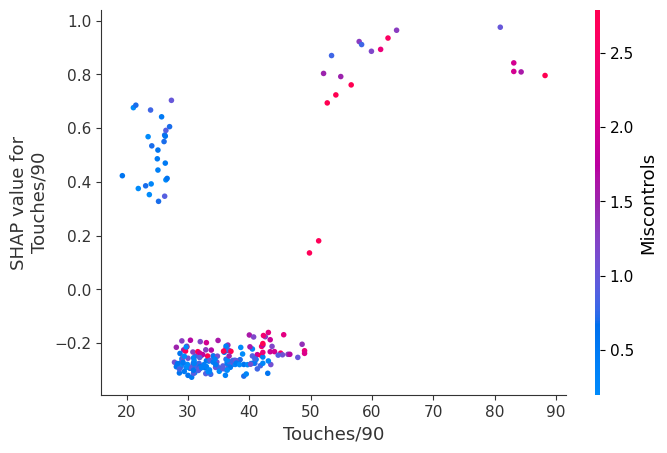

In [126]:
shap.dependence_plot(
    "Age",
    shap_values,
    X_processed,
    feature_names=X_full.columns
)

shap.dependence_plot(
    "Touches/90",
    shap_values,
    X_processed,
    feature_names=X_full.columns
)
